In [1]:
import numpy as np
import open3d as o3d
import dlib
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
def load_calibration(calibration_path):
    "loads me the calibration data from the eth data"
    matrix_rows = []
    with open(calibration_path, 'r') as f: 
        datas = f.readlines()
    for data in datas[:3]:
        row_values = [float(x) for x in data.split()]
        matrix_rows.append(row_values)
    calibration_matrix = np.array(matrix_rows)
        
    return calibration_matrix


In [3]:
load_calibration("/bachelorthesis/biwi_kinect_head_pose/biwi_head_pose/01/depth.cal")


array([[575.816,   0.   , 320.   ],
       [  0.   , 575.816, 240.   ],
       [  0.   ,   0.   ,   1.   ]])

In [4]:
def load_pose(pose_path):
    data = np.loadtxt(pose_path)
    T = np.eye(4)
    T[:3, :3] = data[:3] 
    T[:3, 3] = data[3] 

    return T 

In [5]:
load_pose("/bachelorthesis/biwi_kinect_head_pose/biwi_head_pose/01/frame_00003_pose.txt")

array([[ 9.97978e-01,  2.72944e-02,  5.74071e-02,  5.19358e+01],
       [-3.46956e-02,  9.90621e-01,  1.32163e-01,  3.82631e+01],
       [-5.32613e-02, -1.33887e-01,  9.89564e-01,  8.81756e+02],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00]])

In [14]:
def save_obj_manually(path, points, colors=None):
    """
    Saves points to OBJ manually. 
    Fixes the 'unknown file extension' error Open3D throws for point-only OBJs.
    """
    with open(path, 'w') as f:
        f.write(f"# Cropped Face Point Cloud - {len(points)} points\n")
        for i, p in enumerate(points):
            line = f"v {p[0]:.6f} {p[1]:.6f} {p[2]:.6f}"
            if colors is not None:
                r, g, b = colors[i]
                line += f" {r:.6f} {g:.6f} {b:.6f}"
            f.write(line + "\n")

# --- Main Function with Visualization ---
def process_data(obj_path, img_path, pose_path, cal_path, output_path):
    # A. Load Data
    if not os.path.exists(obj_path):
        print(f"Error: OBJ not found: {obj_path}")
        return

    mesh = o3d.io.read_triangle_mesh(obj_path)
    points = np.asarray(mesh.vertices)
    
    if len(points) == 0:
        print("Error: Mesh has no vertices.")
        return

    image = cv2.imread(img_path)
    h, w = image.shape[:2]

    K = load_calibration(cal_path)
    pose = load_pose(pose_path)

    # B. Detect Face
    print("Detecting Face...")
    try:
        detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")
    except RuntimeError:
        print("Error: Missing 'mmod_human_face_detector.dat'")
        return

    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dets = detector(rgb_image, 1)

    if len(dets) == 0:
        print("No face detected.")
        return

    rect = dets[0].rect
    pad = 30
    left = max(0, rect.left() - pad)
    top = max(0, rect.top() - pad)
    right = min(w, rect.right() + pad)
    bottom = min(h, rect.bottom() + pad)
    
    # C. Transform & Filter
    ones = np.ones((points.shape[0], 1))
    points_hom = np.hstack((points, ones))
    
    # Transform: Model Space -> Camera Space
    points_cam = (pose @ points_hom.T).T 

    x = points_cam[:, 0]
    y = points_cam[:, 1]
    z = points_cam[:, 2]

    # Project: Camera Space -> Image Pixels
    u = (x * K[0,0] / z) + K[0,2]
    v = (y * K[1,1] / z) + K[1,2]

    # Filter
    valid_z = z > 0
    in_box = (u >= left) & (u <= right) & (v >= top) & (v <= bottom)
    final_mask = valid_z & in_box
    
    filtered_points = points[final_mask]
    print(f"Kept {len(filtered_points)} / {len(points)} points.")

    # D. Save
    if len(filtered_points) == 0:
        print("Warning: 0 points remaining.")
        return

    colors_to_save = None
    if mesh.has_vertex_colors():
        colors = np.asarray(mesh.vertex_colors)
        colors_to_save = colors[final_mask]

    save_obj_manually(output_path, filtered_points, colors_to_save)
    print(f"Saved to: {output_path}")

    # --- E. VISUALIZATION ---
    print("Displaying result...")
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_image)
    
    # Plot only the points we kept (using the mask)
    plt.scatter(u[final_mask], v[final_mask], c='lime', s=1, alpha=0.5, label='Kept Points')
    
    # Draw the bounding box for reference
    plt.plot([left, right, right, left, left], [top, top, bottom, bottom, top], 'r-', linewidth=2, label='Face Box')
    
    plt.xlim(0, w)
    plt.ylim(h, 0)
    plt.legend()
    plt.title(f"Result: {len(filtered_points)} Points on Face")
    plt.show()

Detecting Face...
Kept 6765 / 6918 points.
Saved to: /bachelorthesis/output/output.obj
Displaying result...


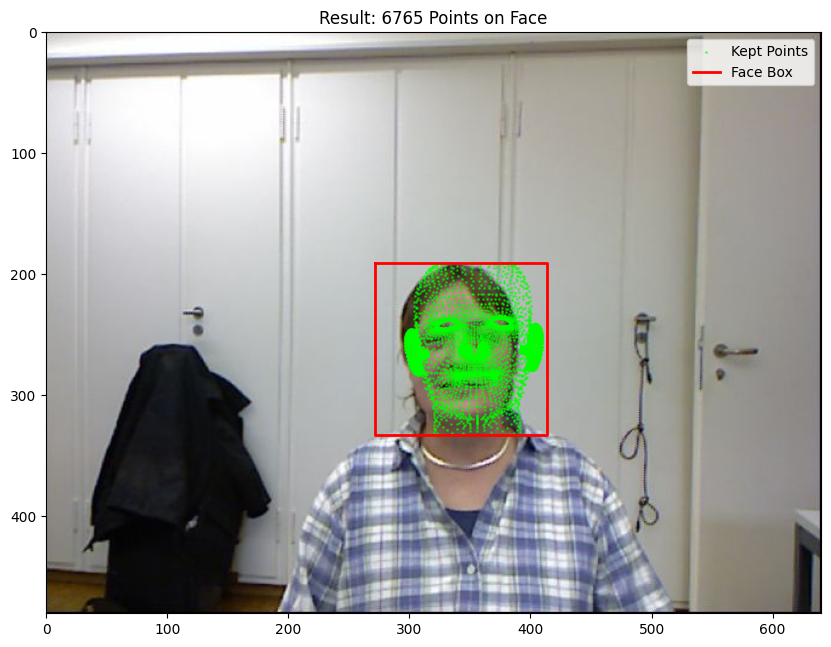

In [15]:
process_data(
        obj_path="/bachelorthesis/biwi_kinect_head_pose/biwi_head_pose/01.obj",
        img_path="/bachelorthesis/biwi_kinect_head_pose/biwi_head_pose/01/frame_00003_rgb.jpg",
        pose_path="/bachelorthesis/biwi_kinect_head_pose/biwi_head_pose/01/frame_00003_pose.txt",
        cal_path="/bachelorthesis/biwi_kinect_head_pose/biwi_head_pose/01/depth.cal",
        output_path="/bachelorthesis/output/output.obj"
    )

Loading data...


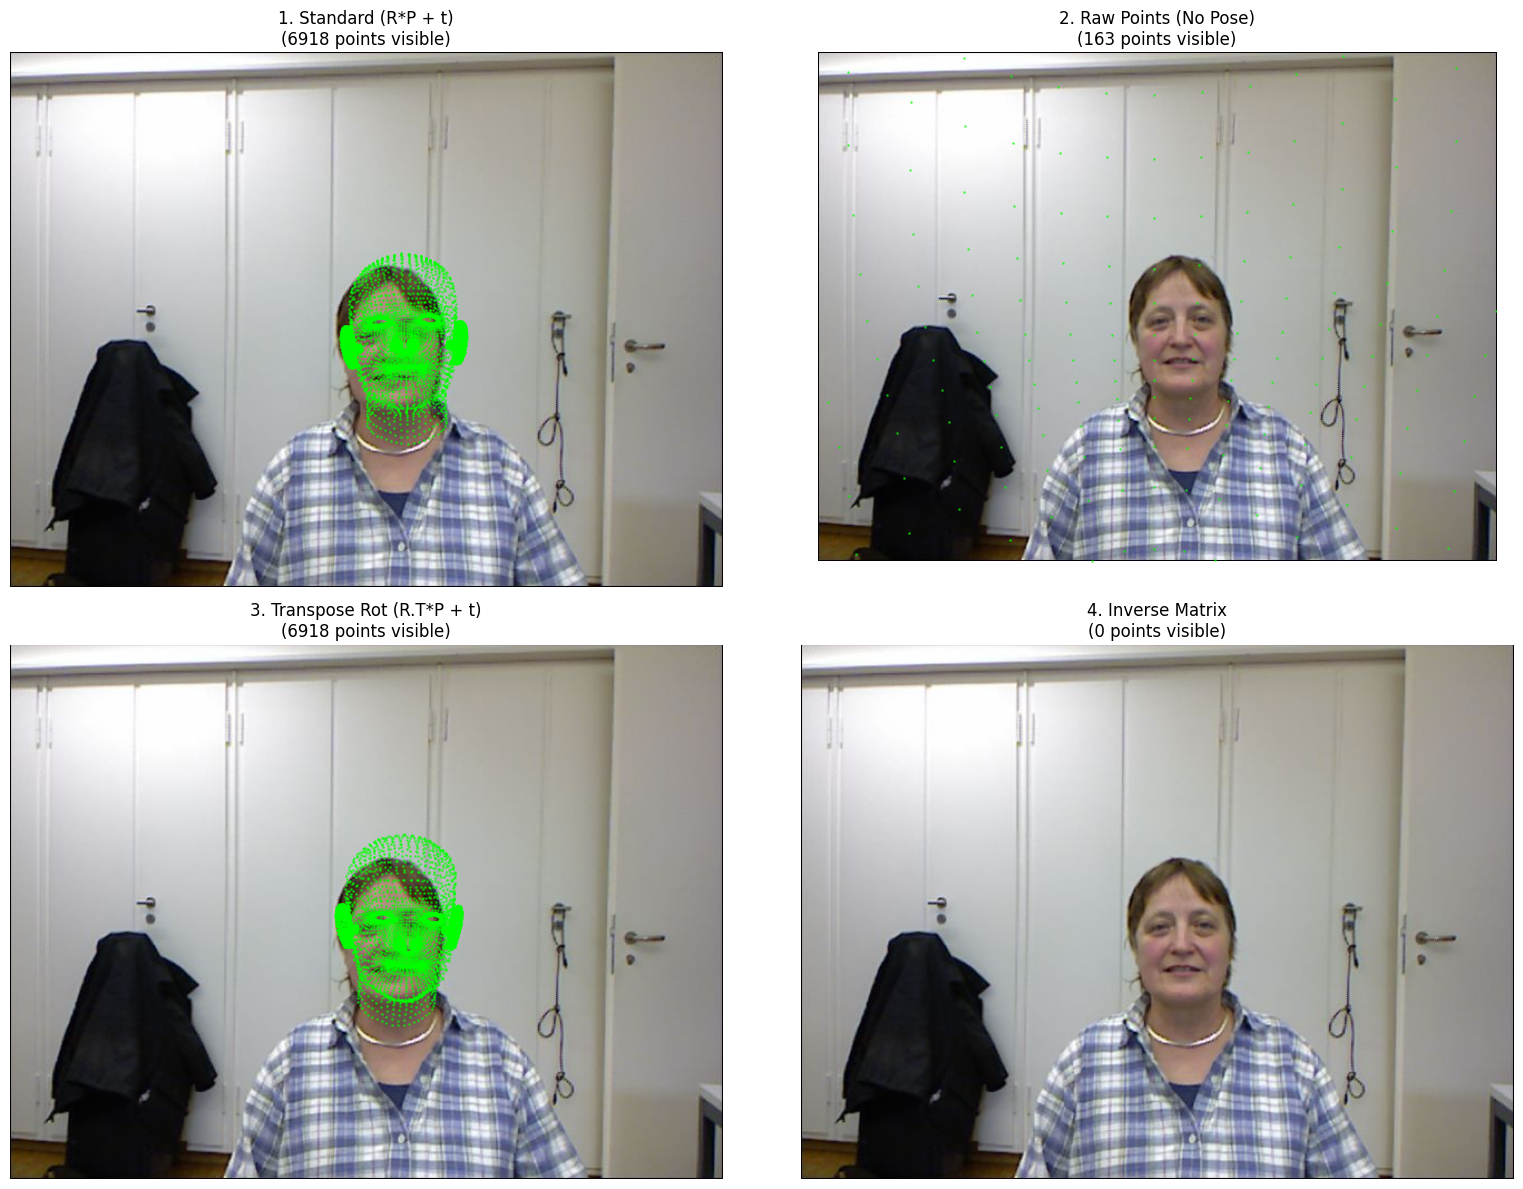